2025-08-22 16:14:58.922983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755879299.237895      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755879299.330688      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loaded: (433, 224, 224, 3) (433, 4)


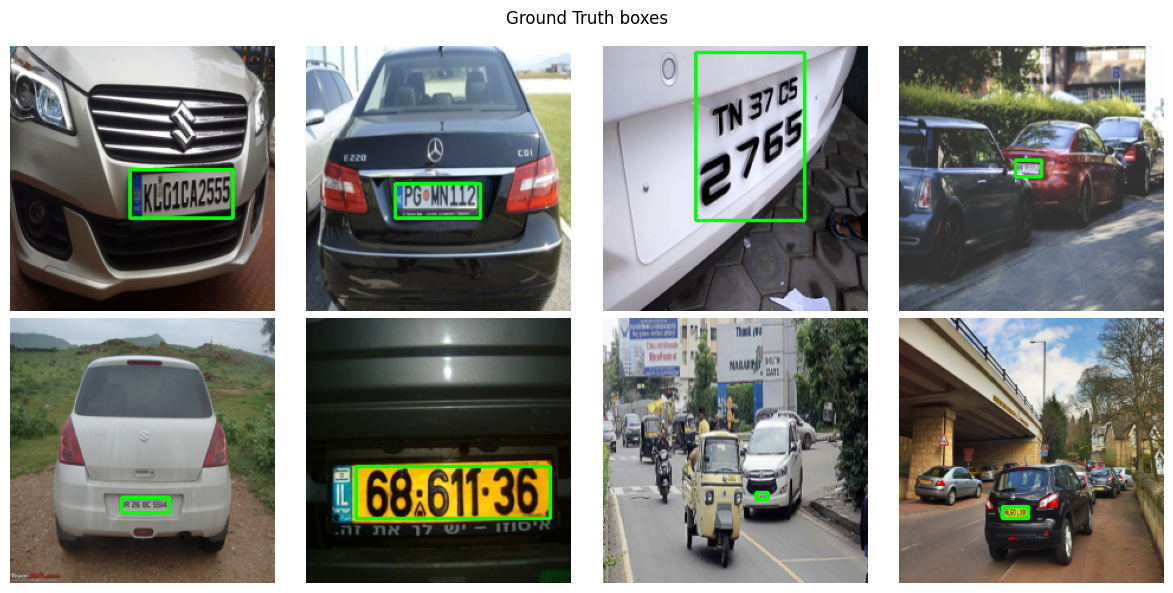

Splits:
  Train: (345, 224, 224, 3) (345, 4)
  Val:   (44, 224, 224, 3) (44, 4)
  Test:  (44, 224, 224, 3) (44, 4)


2025-08-22 16:15:29.782246: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "plate_bbox_regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - iou_metric: 0.0000e+00 - loss: 247.9012 - mae: 124.9496 - val_iou_metric: 0.0000e+00 - val_loss: 240.1694 - val_mae: 121.0847 - learning_rate: 1.0000e-04
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 914ms/step - iou_metric: 0.0000e+00 - loss: 243.5580 - mae: 122.7772 - val_iou_metric: 0.0000e+00 - val_loss: 235.6932 - val_mae: 118.8466 - learning_rate: 1.0000e-04
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 972ms/step - iou_metric: 0.0000e+00 - loss: 239.0170 - mae: 120.5085 - val_iou_metric: 0.0000e+00 - val_loss: 230.6485 - val_mae: 116.3222 - learning_rate: 1.0000e-04
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 917ms/step - iou_metric: 0.0000e+00 - loss: 233.7712 - mae: 117.8839 - val_iou_metric: 0.0000e+00 - val_loss: 225.0227 - val_mae: 113.5102 - learning_rate: 1.0000e-04
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 938ms/step - iou_metric: 0.0000e+00 - loss: 227.9475 - mae: 114.9734 - val_iou_metric: 0.0000e+00 - val_loss: 218.9110 - val_

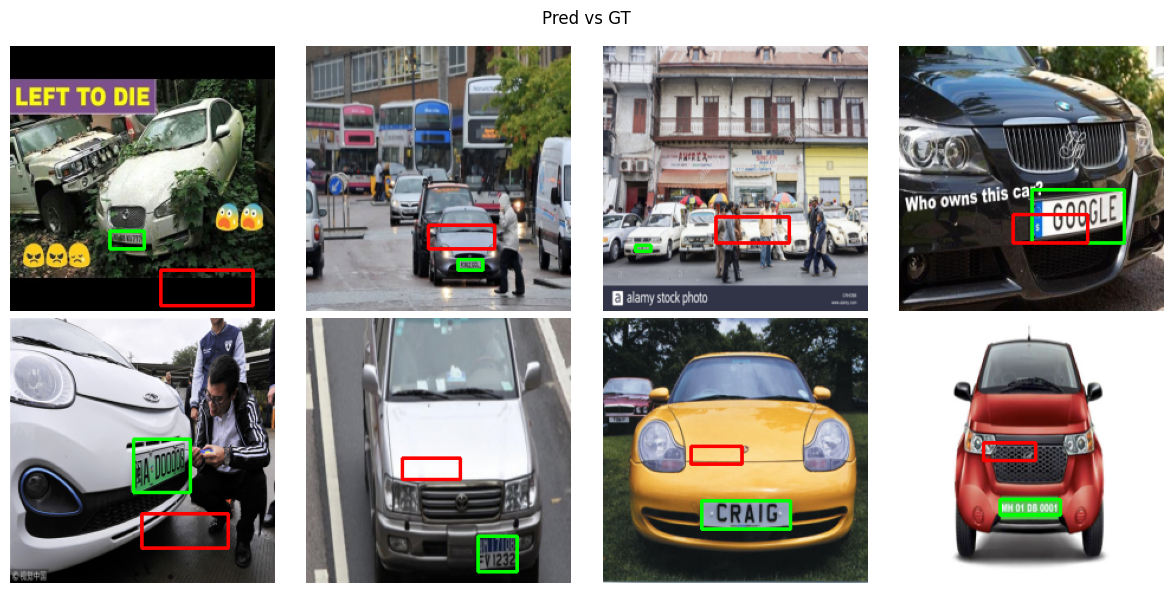

ValueError: No such layer: MobilenetV2. Existing layers are: ['input_layer', 'mobilenetv2_1.00_224', 'global_average_pooling2d', 'dropout', 'dense', 'dropout_1', 'dense_1'].

In [1]:


import os, glob, math, random, gc
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


IMAGE_DIR = "/kaggle/input/car-plate-detection/images"
ANNOT_DIR = "/kaggle/input/car-plate-detection/annotations"


IMAGE_SIZE = 224   
BATCH_SIZE = 32
EPOCHS = 30
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
BACKBONE_TRAINABLE = False  



def parse_voc_xml(xml_path):
   
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    orig_w = int(size.find("width").text)
    orig_h = int(size.find("height").text)

   
    obj = root.find("object")
    if obj is None:
        
        bnd = root.find(".//bndbox")
    else:
        bnd = obj.find("bndbox")

    if bnd is None:
        return (orig_w, orig_h), None

    xmin = int(float(bnd.find("xmin").text))
    ymin = int(float(bnd.find("ymin").text))
    xmax = int(float(bnd.find("xmax").text))
    ymax = int(float(bnd.find("ymax").text))

    return (orig_w, orig_h), [xmin, ymin, xmax, ymax]

def load_dataset(image_dir=IMAGE_DIR, annot_dir=ANNOT_DIR, image_size=IMAGE_SIZE, verbose=True):
    
    xml_files = sorted(glob.glob(os.path.join(annot_dir, "*.xml")))
    X, y, kept = [], [], []

    for xml_path in xml_files:
        base = os.path.splitext(os.path.basename(xml_path))[0]  # e.g., Cars123
        img_path = os.path.join(image_dir, base + ".png")

        if not os.path.exists(img_path):
            # silently skip if image missing
            continue

        
        (orig_w, orig_h), bbox = parse_voc_xml(xml_path)
        if bbox is None or orig_w <= 0 or orig_h <= 0:
            continue

        xmin, ymin, xmax, ymax = bbox
        # sanity check bbox
        if xmax <= xmin or ymax <= ymin:
            continue

        
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        scale_x, scale_y = image_size / orig_w, image_size / orig_h
        img_resized = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)

        
        xmin_r = int(round(xmin * scale_x))
        xmax_r = int(round(xmax * scale_x))
        ymin_r = int(round(ymin * scale_y))
        ymax_r = int(round(ymax * scale_y))

        
        xmin_r = max(0, min(image_size - 1, xmin_r))
        ymin_r = max(0, min(image_size - 1, ymin_r))
        xmax_r = max(0, min(image_size - 1, xmax_r))
        ymax_r = max(0, min(image_size - 1, ymax_r))
        if xmax_r <= xmin_r or ymax_r <= ymin_r:
            continue

        X.append(img_resized)
        y.append([xmin_r, ymin_r, xmax_r, ymax_r])
        kept.append((img_path, xml_path))

    X = np.asarray(X, dtype=np.float32) / 255.0
    y = np.asarray(y, dtype=np.float32)

    if verbose:
        print(f"Loaded: {X.shape} {y.shape}")
        if len(X) == 0:
            print("No data loaded. Check your paths and XML structure.")

    return X, y, kept

def draw_box(image, box, color=(255, 0, 255), thickness=2):
    """Draw a rectangle box [xmin, ymin, xmax, ymax] on an RGB image and return a copy."""
    img = image.copy()
    x1, y1, x2, y2 = map(int, box)
    return cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

def show_examples(X, y, rows=2, cols=4, preds=None, title="Samples"):
    """Quick grid visualization of images with GT (and optional predicted) boxes."""
    n = min(rows * cols, len(X))
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        img = (X[i] * 255).astype(np.uint8)
        img = draw_box(img, y[i], color=(0, 255, 0), thickness=2)  # GT in green
        if preds is not None:
            img = draw_box(img, preds[i], color=(255, 0, 0), thickness=2)  # Pred in red
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


X_all, y_all, kept_files = load_dataset()


if len(X_all) > 0:
    show_examples(X_all, y_all, rows=2, cols=4, title="Ground Truth boxes")


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SPLIT, random_state=SEED, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SPLIT/(1.0-TEST_SPLIT), random_state=SEED, shuffle=True
)

print("Splits:")
print("  Train:", X_train.shape, y_train.shape)
print("  Val:  ", X_val.shape,   y_val.shape)
print("  Test: ", X_test.shape,  y_test.shape)


def build_model(image_size=IMAGE_SIZE, backbone_trainable=BACKBONE_TRAINABLE):
    inputs = keras.Input(shape=(image_size, image_size, 3))

   
    base = keras.applications.MobileNetV2(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = backbone_trainable

    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(4, activation="linear")(x)

    model = keras.Model(inputs, outputs, name="plate_bbox_regressor")
    return model

model = build_model()
model.summary()


def iou_metric(y_true, y_pred):
    # y: [xmin, ymin, xmax, ymax]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    xA = tf.maximum(y_true[:, 0], y_pred[:, 0])
    yA = tf.maximum(y_true[:, 1], y_pred[:, 1])
    xB = tf.minimum(y_true[:, 2], y_pred[:, 2])
    yB = tf.minimum(y_true[:, 3], y_pred[:, 3])

    inter_w = tf.maximum(0.0, xB - xA)
    inter_h = tf.maximum(0.0, yB - yA)
    inter_area = inter_w * inter_h

    true_area = tf.maximum(0.0, (y_true[:, 2] - y_true[:, 0])) * tf.maximum(0.0, (y_true[:, 3] - y_true[:, 1]))
    pred_area = tf.maximum(0.0, (y_pred[:, 2] - y_pred[:, 0])) * tf.maximum(0.0, (y_pred[:, 3] - y_pred[:, 1]))

    union = true_area + pred_area - inter_area + 1e-7
    iou = inter_area / union
    return tf.reduce_mean(iou)


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.Huber(delta=2.0),  # Smooth L1 style
    metrics=["mae", iou_metric]
)


callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint("best_bbox_model.keras", monitor="val_loss", save_best_only=True)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)


eval_loss, eval_mae, eval_iou = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest → Loss: {eval_loss:.4f} | MAE(px): {eval_mae:.2f} | IoU: {eval_iou:.3f}")


def predict_and_show(model, X, y, count=8, title="Pred vs GT"):
    idxs = np.random.choice(len(X), size=min(count, len(X)), replace=False)
    preds = model.predict(X[idxs], verbose=0)
    preds = np.clip(preds, 0, IMAGE_SIZE)  

    show_examples(X[idxs], y[idxs], rows=2, cols=4, preds=preds, title=title)

predict_and_show(model, X_test, y_test, count=8)


In [2]:


FINE_TUNE = True   

if FINE_TUNE:
    
    try:
        base = model.get_layer("mobilenetv2_1.00_224")  # name used by default
    except:
       
        base = model.get_layer("MobilenetV2")  
    
    
    base.trainable = True

    
    for layer in base.layers[:-20]:
        layer.trainable = False

    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="mse",
        metrics=["mae"]
    )

    
    history_ft = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32
    )


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 1698.3004 - mae: 32.2873 - val_loss: 1356.0930 - val_mae: 29.5347
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1589.6123 - mae: 30.9163 - val_loss: 1335.1204 - val_mae: 29.1018
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1492.1777 - mae: 30.4316 - val_loss: 1315.1403 - val_mae: 28.7062
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1368.6467 - mae: 28.8487 - val_loss: 1296.1044 - val_mae: 28.3737
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1377.4231 - mae: 28.8179 - val_loss: 1280.8907 - val_mae: 28.0996
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1276.9858 - mae: 27.4000 - val_loss: 1267.9904 - val_mae: 27.8923
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 1251.1124 - mae: 27.0036 - val_loss: 1257.2844 - val_mae: 27.7196
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1231.7677 - mae: 27.1953 - val_loss: 1246.7599 - val_mae: 27.5714
Epoch 9/

In [3]:
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation MAE: {mae:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - loss: 1253.8158 - mae: 27.6553
Validation Loss: 1231.9683, Validation MAE: 27.4449


In [4]:
model.save("car_plate_detector.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


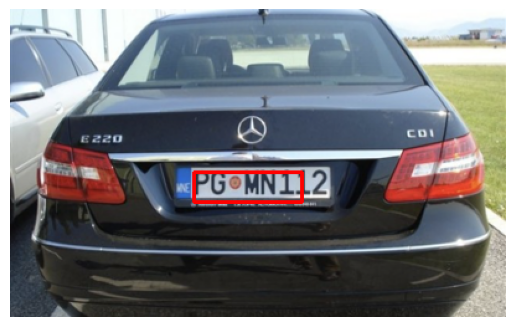

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def predict_and_show(image_path, model, image_size=224):
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig = img.copy()
    h, w = orig.shape[:2]

    img_resized = cv2.resize(img, (image_size, image_size)) / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    
    pred = model.predict(img_resized)[0]
    xmin, ymin, xmax, ymax = pred.astype(int)

    
    scale_x, scale_y = w / image_size, h / image_size
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    
    cv2.rectangle(orig, (xmin, ymin), (xmax, ymax), (255,0,0), 2)

    
    plt.imshow(orig)
    plt.axis("off")
    plt.show()

# Example usage
predict_and_show("/kaggle/input/car-plate-detection/images/Cars1.png", model)
